<a href="https://colab.research.google.com/github/yashrex12/KNN_CLassifier/blob/master/KNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install torchvision

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import torchvision

(150, 4) (150,)


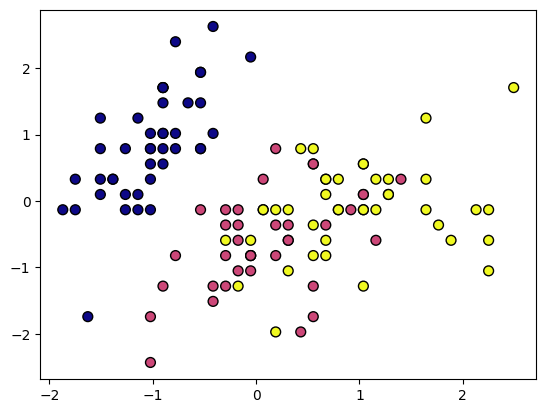

In [3]:
# load iris dataset, this dataset contains 150 datapoints with 4 features
iris = datasets.load_iris()
# extract iris data into a numpy array
iris_data = iris.data
scaler = StandardScaler()
scaler.fit(iris_data)
iris_data = scaler.transform(iris_data)
# extract iris label into a numpy array, labels are integers: 0, 1, 2
iris_label = iris.target

iris_data, iris_label = shuffle(iris_data, iris_label)

print(iris_data.shape, iris_label.shape)

# initialize the training set split as 0.8 for 80%
train_index = int(len(iris_data) * 0.8)

# 80% training and 20% test Split on the iris data
x_train, x_test = iris_data[:train_index], iris_data[train_index:]

# 80% training and 20% test Split on the iris data labels
y_train, y_test = iris_label[:train_index], iris_label[train_index:]

# plot the graph of number of elements of second v first feature
plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, cmap='plasma', s=50, edgecolors='k')
plt.show()

In [4]:
from collections import Counter
class KNearestNeighbor:
    def __init__(self, x, y):
        """
        Initialise the kNN classifier, memorize the input data and label.

        Inputs:
        - x: A numpy array containing the dataset of shape (num_data, D),
        with num_data being the number of datapoints of dimension D
        - y: A numpy array containing the labels of shape (num_data,),
        y[i] is the label of x[i]
        """
        self.data = x
        self.labels = y

    @staticmethod
    def l1_distance(a, b):
        """
        Calculate the l1 distance between two numpy arrays a and b.
        Inputs:
        - a: A numpy array
        - b: A numpy array

        Returns:
        -  : The L1 distance between a and b
        """
        dist_l1 = np.sum(np.abs(a - b))
        return dist_l1

    @staticmethod
    def l2_distance(a, b):
        """
        Calculate the l2 distance between two numpy arrays a and b.
        Inputs:
        - a: A numpy array
        - b: A numpy array

        Returns:
        -  : The L2 distance between a and b
        """
        dist_l2 = np.sqrt(np.sum((a - b)**2))
        return dist_l2

    def predict(self, x, k, dist_type='l1'):
        """
        Given a test point x, predict its class.

        Inputs:
        - x: A numpy array containing the test datapoint.
        - k: k value for kNN, number of nearest neighbors.
        - dist_type: use to choose distance functions: l1, l2 and rep_l2.

        Returns:
        - : The class of datapoint x in integer
        """
        distances = []
        nearest_labels = []

        # Calculate distances from x to each point in the training set
        for data_point in x_train:
            if dist_type == 'l1':
                distance = self.l1_distance(x, data_point)
            elif dist_type == 'l2':
                distance = self.l2_distance(x, data_point)
            distances.append(distance)

        # Get indices of k nearest neighbors
        nearest_indices = np.argsort(distances)[:k]

        # Get labels of k nearest neighbors
        nearest_labels = (y_train[nearest_indices])

        # Count occurrences of each label
        label_counts = Counter(nearest_labels)

        # Get the most common label
        final_label = label_counts.most_common(1)[0][0]

        return final_label

In [5]:
knn = KNearestNeighbor(x_train, y_train)

def evaluate(knn_classifier, x_eval, y_eval, k, dist_type='l1', return_preds=False):
    """
    Use kNN to predict values of x_eval.
    Then use the predicted values and y_eval to report classifier performance.
    Returns the point-wise accuracy.
    The point-wise accuracy is the number of true positives over the total number of data points.

    Inputs:
        - knn_classifier: Your kNN classifier
        - x_eval: A numpy array of shape (num_eval, D) containing the evaluation dataset
          consisting of num_eval samples each of dimension D.
        - y_eval: A numpy array of shape (num_eval,) containing the evaluation dataset labels, where
              y_eval[i] is the label for x_eval[i]
        - k: k value for kNN, number of nearest neighbors.
        - dist_type: use to choose distance functions: l1, l2 and rep_l2.
        - return_preds: set to true to return a list containing the predictions.

    Returns:
        - : The point-wise accuracy in the range of [0, 1]
        - : optional: a list containing the predictions
    """
    preds = np.array([knn_classifier.predict(x, k, dist_type=dist_type) for x in x_eval])
    tp = np.sum(preds==y_eval)
    if return_preds:
      return tp/len(y_eval), preds
    return tp/len(y_eval)


#%%

def kfold_validation(knn_classifier, x, y, k, dist_type):
    num_samples = len(x)
    fold_size = num_samples // 5          # 5 folds
    accuracies = []
    knn = KNearestNeighbor(x_train, y_train)

    # Create 5 folds of the training data set for cross-validation
    for i in range(5):
        start_index = i * fold_size
        end_index = min((i + 1) * fold_size, num_samples)

        # Feature and label data, respectively, for the validation set within the current fold.
        x_val_fold = x[start_index:end_index]
        y_val_fold = y[start_index:end_index]

        # Feature and label data, respectively, for the training set within the current fold
        x_train_fold = np.concatenate([x[:start_index], x[end_index:]])
        y_train_fold = np.concatenate([y[:start_index], y[end_index:]])

        # Use the evaluate() function on the folds and report the mean accuracy
        knn_fold = KNearestNeighbor(x_train_fold, y_train_fold)
        accuracy = evaluate(knn_fold, x_val_fold, y_val_fold, k=k, dist_type=dist_type)
        accuracies.append(accuracy)

    return np.mean(accuracies)

# Initialize the best accuracy, distance metric and the best k
k_best = None
accuracy_best = 0.0
dist_type_best = None

# Loop over each k value
for k in range(3, 8):
    # Compare and update the best distance metric between l1 and l2
    l1_accuracy = kfold_validation(knn, x_train, y_train, k, dist_type='l1')
    l2_accuracy = kfold_validation(knn, x_train, y_train, k, dist_type='l2')
    if l1_accuracy > l2_accuracy:
      dist_type_best = 'l1'
    else:
      dist_type_best = 'l2'

    # use the new distance metric to find the best k value and report the final accuracy on training set
    accuracy = kfold_validation(knn, x_train, y_train, k=k, dist_type=dist_type_best)
    if accuracy > accuracy_best:
        accuracy_best = accuracy
        k_best = k

print("Best metric: ", dist_type_best)
print("Best accuracy: ", accuracy_best)
print("Best k: ", k_best)


Best metric:  l2
Best accuracy:  0.9916666666666668
Best k:  6


In [6]:
# Initialize the knn classifier
knn = KNearestNeighbor(x_train, y_train)

# Evaluate the accuracy on test set
test_accuracy = evaluate(knn, x_test, y_test, k=k_best, dist_type=dist_type_best)

# Report the accuracy on the test set
print("Accuracy on the test set:", test_accuracy)

Accuracy on the test set: 0.9333333333333333


100%|██████████| 170498071/170498071 [00:03<00:00, 52032439.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
(4000, 32, 32, 3) (4000,)
(1000, 32, 32, 3) (1000,)
(500, 32, 32, 3) (500,)


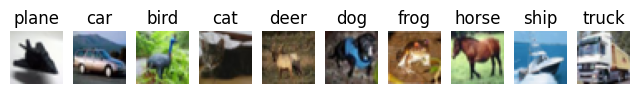

In [8]:
# load CIFAR-10 dataset with pytorch

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

x_train = trainset.data[:4000]
y_train = np.array(trainset.targets)[:4000]

x_val = trainset.data[4000:5000]
y_val = np.array(trainset.targets)[4000:5000]

x_test = testset.data[:500]
y_test = np.array(testset.targets)[:500]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


class_map = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9:'truck'}
###############################################################################
# TODO:                                                                       #
# Visualise 1 sample of each class from train set (x_train)                   #
###############################################################################
# *****BEGIN YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Define the figure and no. of colums in the plot
fig, axes = plt.subplots(1, 10, figsize=(8,1))

for i in range(10):
  class_images = x_train[y_train==i]
  sample_image = class_images[0]
  axes[i].imshow(sample_image)
  axes[i].set_title(class_map[i])
  axes[i].axis('off')

plt.show()

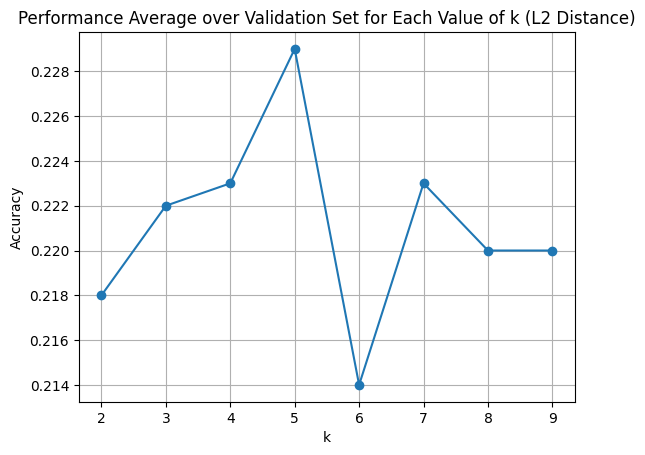

In [9]:
# Initialize kNN classifier
knn = KNearestNeighbor(x_train, y_train)

# Define a range of k values to evaluate
k_values = range(2, 10)  # Consider k values from 1 to 20


accuracy_values = []
# Loop over each k value
for k in k_values:
    # Evaluate the classifier using the current k value and L2 distance
    accuracy = evaluate(knn, x_val, y_val, k=k, dist_type='l2')
    accuracy_values.append(accuracy)

# Plot the performance average over the validation set for each value of k
plt.plot(k_values, accuracy_values, marker='o')
plt.title('Performance Average over Validation Set for Each Value of k (L2 Distance)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.show()

Test set accuracy with k = 5 and l2 distance: 0.22


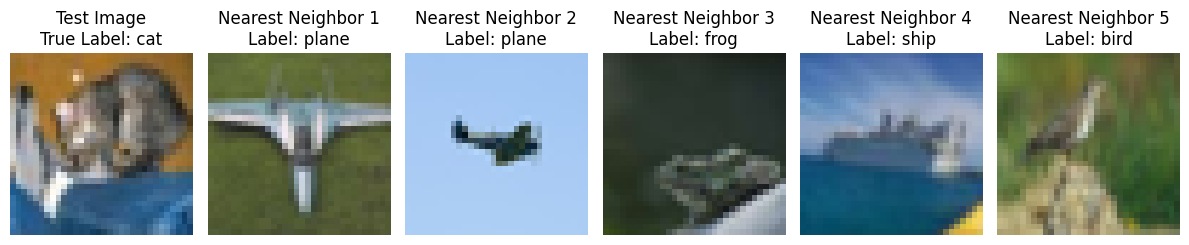

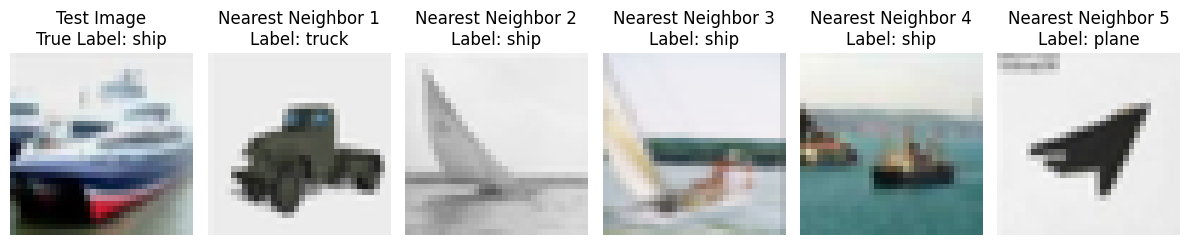

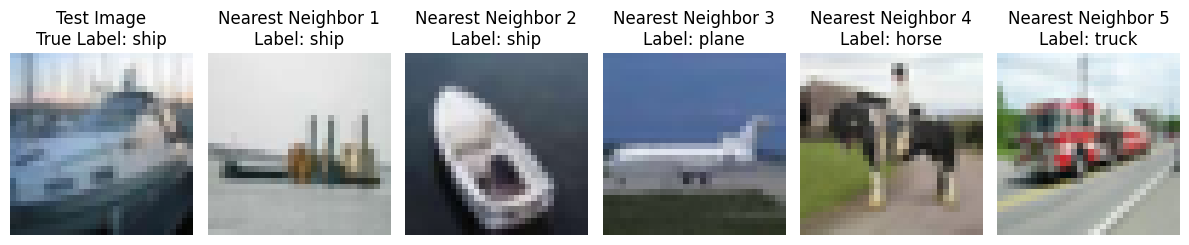

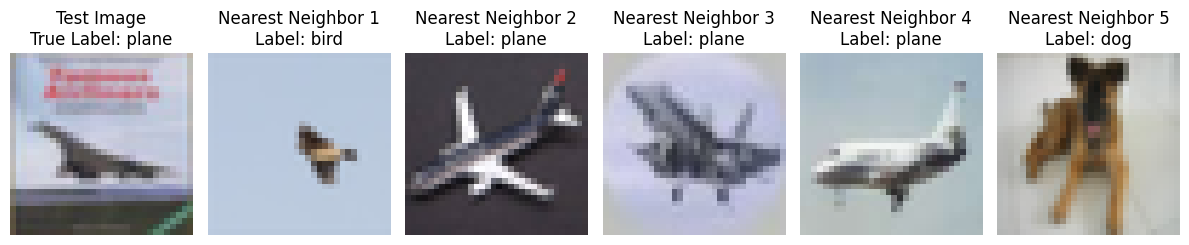

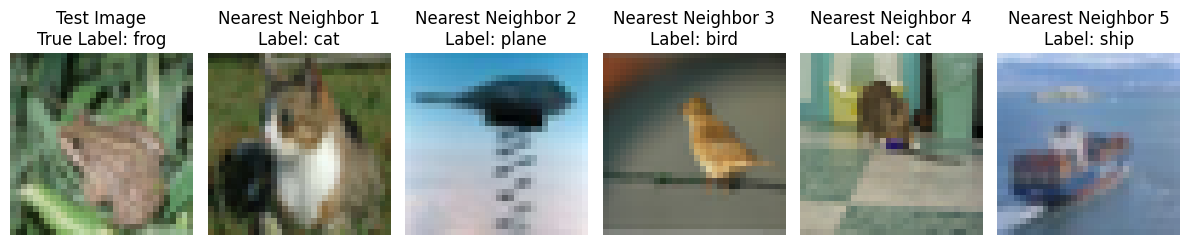

In [10]:
best_k = 5
dist_type = 'l2'
test_accuracy = evaluate(knn, x_test, y_test, k=best_k, dist_type=dist_type)
print("Test set accuracy with k =", best_k, "and", dist_type, "distance:", test_accuracy)

# Visualize the k-nearest neighbors for the first 5 datapoints in the test set
for i in range(5):
    test_point = x_test[i]
    true_label = class_map[y_test[i]]

    # Find the k-nearest neighbors for the current test point
    distances = [knn.l2_distance(test_point, x_train[j]) for j in range(len(x_train))]
    nearest_indices = np.argsort(distances)[:best_k]
    nearest_images = x_train[nearest_indices]
    nearest_labels = y_train[nearest_indices]

    # Plot the original test image and its k-nearest neighbors
    fig, axes = plt.subplots(1, best_k+1, figsize=(12, 4))
    axes[0].imshow(test_point)
    axes[0].set_title("Test Image\nTrue Label: " + true_label)
    axes[0].axis('off')

    for j in range(best_k):
        axes[j+1].imshow(nearest_images[j])
        axes[j+1].set_title("Nearest Neighbor {}\nLabel: {}".format(j+1, class_map[nearest_labels[j]]))
        axes[j+1].axis('off')

    plt.tight_layout()
    plt.show()